# Social Media Sanctions and Misinformation Sharing

To start with, we need to import the necessary libraries

In [165]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import multipletests

## Twitter Suspensions after the 2020 Election

To explain twiter suspensions, we read the csv and select the columns that will be used for the crosstabulation.

In [166]:
data = pd.read_csv('mosleh_et_al_data.csv')
hastags_and_suspension = data[['politics_hashtag','suspended']]

In [167]:
crosstab = pd.crosstab(hastags_and_suspension['politics_hashtag'], hastags_and_suspension['suspended'])
crosstab

suspended,0,1
politics_hashtag,,
0,4295,200
1,3623,882


In [168]:
republicans_ratio = crosstab.loc[1,1]/crosstab.loc[1].sum()
democrats_ratio = crosstab.loc[0,1]/crosstab.loc[0].sum()
print(f'{republicans_ratio /democrats_ratio:.1f}')

4.4


From the crosstabulation emerges the interesting fact that accounts that shared `#Trump2020` during the election were about 4.4 times more likely to be subsequently suspended than the accounts that shared `#VoteBidenHarris2020` 

In [169]:
chi2, p, dof, expected = chi2_contingency(crosstab)
print("Chi-Square Statistic:", chi2)
print("P-Value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 485.46706126582285
P-Value: 1.3808204811294585e-107
Degrees of Freedom: 1
Expected Frequencies:
[[3954.60111111  540.39888889]
 [3963.39888889  541.60111111]]


* Ho: There is no association between the use of politics_hashtag (#Trump2020 vs. #VoteBidenHarris2020) and account suspension status
* H1: There is an association between the use of politics_hashtag and account suspension status.

Since p-value << 0.05, we reject the null hypothesis. That can be seen also from the fact that the observed frequencies are very different from the expected frequencies, meaning the values we expect if variables were independent (540 instaed of 200 and 541 instead of 882). Therefore, we could conclude that political party interacts with the suspension of the account.

## Distributions of Relative Frequency of Low Quality

Let's examine the distributions of low-quality sharing as determined by eight professional fact-checkers (column `lowqual_pr2019_fc`), grouped by `politics_hashtag`. 

In [170]:
factcheckers_lowquality_and_hastags = data[['lowqual_pr2019_fc','politics_hashtag']]
factcheckers_lowquality_and_hastags.loc[:, 'lowqual_pr2019_fc'] = StandardScaler().fit_transform(factcheckers_lowquality_and_hastags[['lowqual_pr2019_fc']])

C:\Users\karyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\karyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


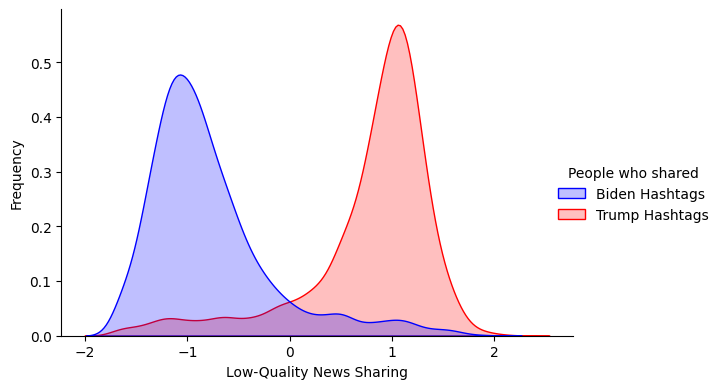

In [171]:
category_colors = {
    0: "blue",  
    1: "red"    
}

# Create the displot
g = sns.displot(
    data=factcheckers_lowquality_and_hastags, 
    x='lowqual_pr2019_fc', 
    hue='politics_hashtag', 
    kind='kde', 
    fill=True, 
    height=4, 
    aspect=1.5, 
    palette=category_colors
)

# Set labels
plt.xlabel('Low-Quality News Sharing')
plt.ylabel('Frequency')

new_labels = ['Biden Hashtags', 'Trump Hashtags']
for text, new_label in zip(g.legend.texts, new_labels):
    text.set_text(new_label)
g.legend.set_title("People who shared")
plt.show()


We can now proceed to do the same with low-quality sharing as determined by crowdsourcing

In [172]:
crowd_lowquality_and_hastags = data[['lowqual_pr2019_crowd','politics_hashtag']]
crowd_lowquality_and_hastags.loc[:, 'lowqual_pr2019_crowd'] = StandardScaler().fit_transform(crowd_lowquality_and_hastags[['lowqual_pr2019_crowd']])

C:\Users\karyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\karyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


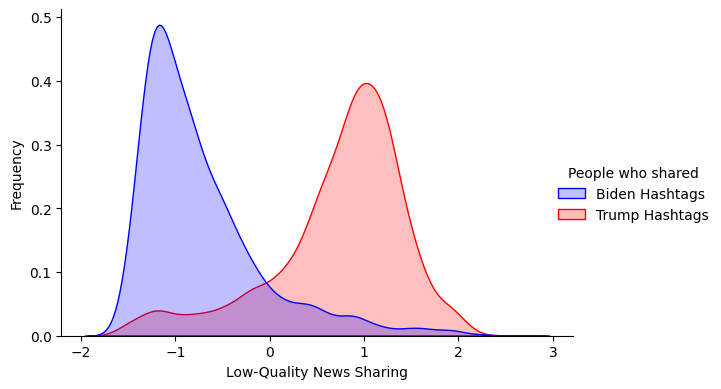

In [173]:
g = sns.displot(data=crowd_lowquality_and_hastags, x='lowqual_pr2019_crowd', hue='politics_hashtag', kind='kde',fill=True,  height=4, aspect=1.5, palette=category_colors)
plt.xlabel('Low-Quality News Sharing')
plt.ylabel('Frequency')
new_labels = ['Biden Hashtags', 'Trump Hashtags']
for text, new_label in zip(g.legend.texts, new_labels):
    text.set_text(new_label)
g.legend.set_title("People who shared")
plt.show()

## Low-quality News Sharing on Twitter

To examine low-quality news sharing on Twitter on a more quantitave manner we will use t-test. To do that, we need to approriately format our data to group 0 (democrats) and group 1 (republicans) for each column to be tested.

In [174]:
# Select relevant columns
t_test_data = data[['politics_hashtag', 'lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_mbfc', 
                    'lowqual_lasser2019', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep']]

# Separate data into two groups based on 'politics_hashtag'
group_0 = t_test_data[t_test_data['politics_hashtag'] == 0]
group_1 = t_test_data[t_test_data['politics_hashtag'] == 1]

# Perform t-test for each column
columns_to_test = ['lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_mbfc', 
                   'lowqual_lasser2019', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep']

We will quantify the effect size of the t-test using Cohen's $d$ and Hedges' $g$

In [175]:
def cohen_d(group1, group2):
    diff = abs(group1.mean() - group2.mean())
    n1, n2 = len(group1), len(group2)
    s1_squared = np.var(group1, ddof=1)
    s2_squared = np.var(group2, ddof=1)
    pooled_var = (((n1 -1) * s1_squared + (n2 - 1) * s2_squared) / (n1 + n2 - 2)) ** 0.5
    d = diff / pooled_var
    return d

def hedges_g(group1, group2,d):
    n1, n2 = len(group1), len(group2)
    return (1 - 3 / (4 * (n1 + n2) - 9)) * d

* Hypothesis 0: The two groups have the same mean
* Hypothesis 1: The two groups have different means

In [176]:
t_test_results = []
for column in columns_to_test:
    group_0_col = group_0.loc[:, column]
    group_1_col = group_1.loc[:, column]
    t_stat, p_value = ttest_ind(group_0_col, group_1_col, nan_policy='omit') 
    d = cohen_d(group_0_col, group_1_col)
    g = hedges_g(group_0_col, group_1_col, d)
    
    t_test_results.append({
        "Column": column,
        "t_stat": f"{abs(t_stat):.1f}",
        "p_value": f"{p_value:.2f}",
        "Cohen's d": f"{d:.2f}",
        "Hedges' g": f"{g:.2f}"
    })

results_df = pd.DataFrame(t_test_results)
results_df

,Column,t_stat,p_value,Cohen's d,Hedges' g
0,lowqual_pr2019_fc,119.2,0.00,2.52,2.52
1,lowqual_afm,102.7,0.00,2.16,2.16
2,lowqual_mbfc,97.6,0.00,2.06,2.06
3,lowqual_lasser2019,102.6,0.00,2.16,2.16
4,lowqual_pr2019_crowd,102.5,0.00,2.17,2.17
5,lowqual_pr2019_crowdrep,61.1,0.00,1.29,1.29


All two-sample t-tests about the quality of news shared on Twitter, show that republicans are more prone to low-quality sources.  
According to Cohen's $d$, the effect size of political party on the quality of news is huge ($d$ > 2). Even when the assessment of sites derives from republicans, the effect is still very large ($d$ > 1.2).  
When using Hedges' $g$ to correct the bias of sample size, the interpretation is the same and the effect size is almost identical for all two-sample t-tests.

### Sharing Lower-quality News Sources and Conservative Ideology

To see if there is a correlation between lower-quality news sources and conservative ideology, we will perform pairwise correlations between low-quality news sources and ideology metrics.

In [177]:
quality= data[['lowqual_pr2019_fc','lowqual_lasser2019', 'lowqual_mbfc', 'lowqual_afm', 'lowqual_pr2019_crowd','lowqual_pr2019_crowdrep']]
politics = data[['politics_followed','politics_hashtag','politics_sites1','politics_sites2']]

To create the heatmap we need to create a correlation matrix

In [178]:
table = pd.concat([quality,politics], axis=1)
correlation_matrix = table.corr()
correlation_matrix = correlation_matrix.loc[quality.columns, politics.columns]
correlation_matrix

,politics_followed,politics_hashtag,politics_sites1,politics_sites2
lowqual_pr2019_fc,0.809501,0.783463,0.876237,0.854197
lowqual_lasser2019,0.777250,0.734398,0.835576,0.851794
lowqual_mbfc,0.748146,0.717101,0.774779,0.774266
lowqual_afm,0.768887,0.734562,0.845285,0.833632
lowqual_pr2019_crowd,0.754001,0.734856,0.811904,0.784861
lowqual_pr2019_crowdrep,0.540993,0.542505,0.576336,0.552613


Then, it is very straight-forwarard to visualize the results.

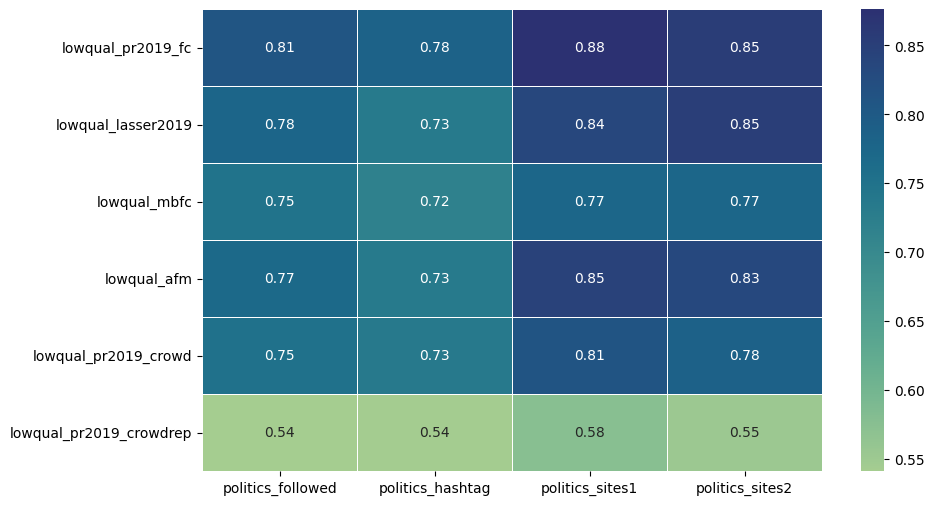

In [179]:
# Create the heatmap

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='crest', 
    fmt=".2f", 
    linewidths=0.5,
)
ax.set(xlabel="", ylabel="")

plt.show()


We can see that low quality of sourcers correlates to the political party, even when we measure by only the trustworthiness ratings or Republican laypeople.

## News Sharing Can Help Explain Suspension, Using Single Predictors

We will use the following predictors to predict whether a user was suspended or not

In [180]:
predictors = ['politics_hashtag','politics_sites1','politics_sites2','politics_followed','lowqual_afm','lowqual_mbfc','lowqual_lasser2019','lowqual_pr2019_fc','lowqual_pr2019_crowd',]
politics = data[['politics_hashtag','politics_sites1','politics_sites2','politics_followed']]
quality = data[['lowqual_afm','lowqual_mbfc','lowqual_lasser2019','lowqual_pr2019_fc','lowqual_pr2019_crowd']]

To create predictions, a good approach is probit regression. To evaluate our predictictions the AUC of the ROC curve is appropriate. Moreover, to get confidence intervals,  we will repeat each prediction 100 times with bootstrap.

In [181]:
evaluation = {}
n_bootstrap = 100

for predictor in predictors:
    probit_data = data[['suspended', predictor]].dropna()
    x = probit_data[predictor]
    formula = f'suspended ~{predictor}'
    model = smf.probit(formula, data=probit_data).fit(disp=False) 
    probit_data['pred_prob'] = model.predict(x)
    results=[]
    for _ in range(100):
        bootstrapped_data = probit_data.sample(frac=1.0, replace=True)
        auc = roc_auc_score(bootstrapped_data['suspended'], bootstrapped_data['pred_prob'])
        results.append(auc)
    mean_auc = np.mean(results)
    lower_ci = np.percentile(results, 2.5)
    upper_ci = np.percentile(results, 97.5)
    if predictor in quality:
        class_ = 'Low-quality news sharing'
    else:
        class_ = 'Political orientation'
    evaluation[predictor] = {'lower_ci': lower_ci, 'mean_auc': mean_auc, 'upper_ci': upper_ci, 'Classes': class_}
evaluation = pd.DataFrame(evaluation).T


In [182]:
formatted_eval = evaluation.copy()
formatted_eval[['lower_ci', 'mean_auc', 'upper_ci']] = formatted_eval[['lower_ci', 'mean_auc', 'upper_ci']].applymap(lambda x: f'{x:.2f}')
formatted_eval

C:\Users\karyo\AppData\Local\Temp\ipykernel_5496\1859620889.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_eval[['lower_ci', 'mean_auc', 'upper_ci']] = formatted_eval[['lower_ci', 'mean_auc', 'upper_ci']].applymap(lambda x: f'{x:.2f}')


,lower_ci,mean_auc,upper_ci,Classes
politics_hashtag,0.67,0.68,0.69,Political orientation
politics_sites1,0.69,0.70,0.72,Political orientation
politics_sites2,0.69,0.71,0.72,Political orientation
politics_followed,0.70,0.72,0.73,Political orientation
lowqual_afm,0.70,0.72,0.73,Low-quality news sharing
lowqual_mbfc,0.69,0.71,0.72,Low-quality news sharing
lowqual_lasser2019,0.69,0.71,0.72,Low-quality news sharing
lowqual_pr2019_fc,0.69,0.70,0.71,Low-quality news sharing
lowqual_pr2019_crowd,0.67,0.69,0.70,Low-quality news sharing


After having mean AUC, lower and upper confidence interval for each predictor, we can visualize the result with a barplot.

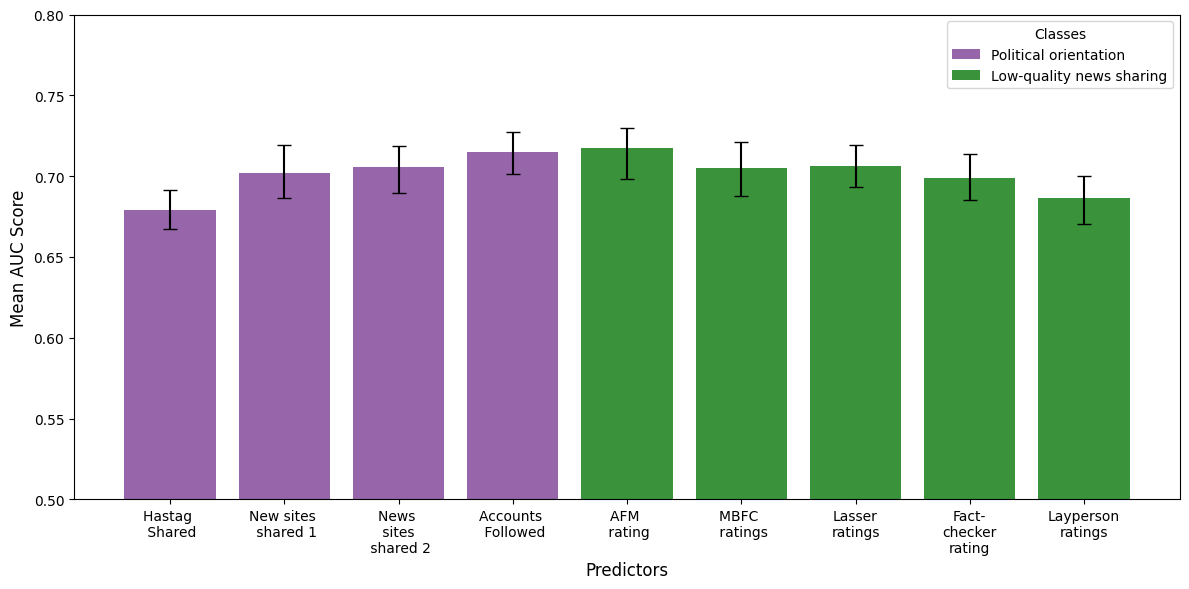

In [183]:
plt.figure(figsize=(12, 6))

# Create the bar plot 
ax = sns.barplot(
    x=evaluation.index, 
    y='mean_auc', 
    hue='Classes',
    data=evaluation, 
    palette=["#9b59b6", "#2ca02c"],
    dodge=False
)

plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Mean AUC Score', fontsize=12)
plt.ylim(0.5, 0.8)

# Get the actual bar positions
bars = ax.containers[0]

# Add centered error bars
for i, (index, row) in enumerate(evaluation.iterrows()):
    # Get the center of the bar
    bar_center = bars[i].get_x() + bars[i].get_width() / 2
    
    plt.errorbar(
        bar_center, 
        row['mean_auc'], 
        yerr=[[row['mean_auc'] - row['lower_ci']], 
              [row['upper_ci'] - row['mean_auc']]], 
        fmt='none', 
        color='black', 
        capsize=5, 
        linewidth=1.5
    )

# Adjust x-ticks to match the center of the bars
tick_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars]
plt.xticks(tick_positions, 
           ['Hastag \n Shared', 
            'New sites \n shared 1', 
            'News \n sites \n shared 2', 
            'Accounts \n Followed', 
            'AFM \n rating', 
            'MBFC \n ratings', 
            'Lasser\nratings', 
            'Fact-\nchecker\nrating', 
            'Layperson\nratings'], 
           rotation=0)

# Adjust layout and display
plt.tight_layout()
plt.show()

Therefore, when examined independently, political orientation and sharing low-quality news are similarly predictive of suspension.

## News Sharing Can Help Explain Suspension, Using Multiple Predictors

* We will start by filing in missing values in your data by using the column mean, as PCA does not accept missing values encoded as NaN natively

In [184]:
regression_data = data.copy()
regression_data = regression_data.fillna(regression_data.mean())

* Log transform using base 10, the variables that are related to Tweeter metrics

In [185]:
twitter_metrics =['repeated_tweet_count','freq_pr_1h','num_followers','num_friends']

for metric in twitter_metrics:
    regression_data[f'log_{metric}'] = np.log10(regression_data[metric] + 1)
    

We must introduce an additional variable, `log_fol`, which should the be base 10 logarithm of `num_friends` over `num_followers` ratio.

In [186]:
regression_data['log_fol'] = np.log10((regression_data['num_friends'] + 1) / (regression_data['num_followers'] +1))

To reduce the effect of outliers, we will winsorize the data. Winzorize from both sides at the top 1% the following variables:

In [187]:
winsorized_both_sides = ['valence_neg','valence_neu','valence_pos','barbera_std','politics_sites1_std','politics_sites2_ideo_std']
for col in winsorized_both_sides:
    regression_data[col] = winsorize(regression_data[col], limits=[0.01, 0.01])

* We winsorize only top 1%

In [188]:
winsorized_upper = ['moral_outrage','rewire_abuse', 'rewire_hate','rewire_profanity','rewire_violent','rewire_sexually_explicit','jigsaw_toxicity','jigsaw_severe_toxicity','jigsaw_idenity_attack','jigsaw_insult','jigsaw_profanity','jigsaw_threat']
for col in winsorized_upper:
    regression_data[col] = winsorize(regression_data[col], limits=[0, 0.01])

* Then, PCA can be used to reduce the number of features, while explaining most of the variance.
* PCA is affected by feature scales, so  data must be standardized

In [189]:
quality_news_sharing = ['lowqual_pr2019_fc','lowqual_afm','lowqual_lasser2019','lowqual_mbfc']
regression_data[quality_news_sharing] = StandardScaler().fit_transform(regression_data[quality_news_sharing])

In [190]:
pca = PCA(n_components=1)
pca.fit(regression_data[quality_news_sharing])
pca.explained_variance_ratio_


array([0.87255953])

* We see that the component explains more than 87% of the variance of our data
* Next, we assign the transformed values of the first principal component to the dataFrame column

In [191]:
regression_data['pc1_misinfo'] = pca.transform(regression_data[quality_news_sharing])

* We will work in the same way for the political orientation, getting a single PCA component, `pc1_politics`

In [192]:
politics = ['politics_hashtag','politics_followed','politics_sites1','politics_sites2']
regression_data[politics] = StandardScaler().fit_transform(regression_data[politics])

In [193]:
pca2 = PCA(n_components=1)
pca2.fit(regression_data[politics])
pca2.explained_variance_ratio_

array([0.87952937])

* Again, the component explains more than 87% of the variance of our data
* Let's introduce a new variable, `extremity`, which is the absolute value of the PCA component we got

In [194]:
regression_data['pc1_politics'] = pca2.transform(regression_data[politics])
regression_data['extremity'] = abs(regression_data['pc1_politics'])

* We can do the same for `log_followers`, `log_friends`, `log_fol`, producing `pc1_fol`

In [195]:
pca3 = PCA(n_components=1)
cols = ['log_num_followers','log_num_friends','log_fol']
regression_data[cols] = StandardScaler().fit_transform(regression_data[cols])

In [196]:
regression_data['pc1_fol'] = pca3.fit_transform(regression_data[cols])
pca3.explained_variance_ratio_

array([0.70462969])

* This time the new feature explains 70% of the variance of our data

* Regarding the harmful language variables, we can perform PCA for *three* components, `pc1_harmful_language`, `pc2_harmful_language`, `pc3_harmful_language`, on the below winsorized data

In [197]:
language = ['rewire_abuse', 'rewire_hate','rewire_profanity','rewire_violent','rewire_sexually_explicit','jigsaw_toxicity','jigsaw_severe_toxicity','jigsaw_idenity_attack','jigsaw_insult','jigsaw_profanity','jigsaw_threat']
regression_data[language] = StandardScaler().fit_transform(regression_data[language])

In [198]:
pca4 = PCA(n_components=3)
pca4.fit(regression_data[language])
regression_data['pc1_harmful_language'], regression_data['pc2_harmful_language'], regression_data['pc3_harmful_language'] = pca4.transform(regression_data[language]).T
print(f'pca for one componenct variance ration : {pca4.explained_variance_ratio_[0]}')
print(f'pca for three componenct variance ration : {pca4.explained_variance_ratio_.sum()}')

pca for one componenct variance ration : 0.5616608005007235
pca for three componenct variance ration : 0.7874157847381192


At this point, it it meaningful to check why we chose 3 components for the PCA.

In [199]:
pca4.explained_variance_ratio_

array([0.5616608 , 0.11871792, 0.10703707])

* First component: Explains ~56.17% of the variance.
* Second component: Explains ~11.87% of the variance.
* Third component: Explains ~10.70% of the variance.  
Using only 1 component means 56.17% of the variance is explained and we're leaving out 43.83% of the variance, which results in losing important information for our analysis.  
So, the choice of 3 components for PCA stems from the fact that using only 1 or 2 componenents is insufficient. When we use 3 components, we manage to capture more than 70% of the variance.

Furthermore, we can try to interpret each of the principal components

In [200]:
pca4.components_

array([[ 0.32530845,  0.23538337,  0.25255674,  0.23252186,  0.12526899,
         0.38547179,  0.33586086,  0.30692208,  0.37440778,  0.3617071 ,
         0.28039267],
       [-0.34409751, -0.5765375 ,  0.23191386, -0.06740265,  0.53686584,
        -0.13232154,  0.30099609,  0.04947252, -0.13741195,  0.20511297,
         0.17646751],
       [-0.30773448, -0.03195551, -0.43039704, -0.03699539, -0.37270948,
        -0.07810217,  0.24571418,  0.46254153, -0.03715369, -0.15336206,
         0.52291043]])

$\text{PC}_1 = 0.3253 \cdot \text{rewire\_abuse} + 0.2354 \cdot \text{rewire\_hate} + 0.2526 \cdot \text{rewire\_profanity} + 0.2325 \cdot \text{rewire\_violent} + 0.1253 \cdot \text{rewire\_sexually\_explicit} + 0.3855 \cdot \text{jigsaw\_toxicity} + 0.3359 \cdot \text{jigsaw\_severe\_toxicity} + 0.3069 \cdot \text{jigsaw\_identity\_attack} + 0.3744 \cdot \text{jigsaw\_insult} + 0.3617 \cdot \text{jigsaw\_profanity} + 0.2804 \cdot \text{jigsaw\_threat}$


The largest coefficients come from jigsaw_toxicity (0.3855), jigsaw_insult (0.3744), and jigsaw_severe_toxicity (0.3359), suggesting that this component captures overall toxicity, abusive behavior, and aggression

$\text{PC}_2 = -0.3441 \cdot \text{rewire\_abuse} - 0.5765 \cdot \text{rewire\_hate} + 0.2319 \cdot \text{rewire\_profanity} - 0.0674 \cdot \text{rewire\_violent} + 0.5369 \cdot \text{rewire\_sexually\_explicit} - 0.1323 \cdot \text{jigsaw\_toxicity} + 0.3010 \cdot \text{jigsaw\_severe\_toxicity} + 0.0495 \cdot \text{jigsaw\_identity\_attack} - 0.1374 \cdot \text{jigsaw\_insult} + 0.2051 \cdot \text{jigsaw\_profanity} + 0.1765 \cdot \text{jigsaw\_threat}$

The largest negative contributions come from `rewire_hate` (-0.5765) and `rewire_abuse` (-0.3441).
This suggests that less hateful and abusive content results in higher $\text{PC}_2$ values, while content with strong hate or abuse brings $\text{PC}_2$ lower.  
`rewire_sexually_explicit` has the highest positive coefficient (0.5369).
This indicates that sexually explicit language is positively associated with $\text{PC}_2$.  
$\text{PC}_2$ seems to capture a "Sexual Explicitness vs. Hate/Abuse" dimension. Higher $\text{PC}_2$ values are driven by sexually explicit and profane content, while lower values are linked to hate and abuse. This dimension might distinguish between types of harmful behavior—for example, separating explicit but non-hateful language from overtly hateful or abusive content.

$\text{PC}_3 = -0.3077 \cdot \text{rewire\_abuse} - 0.0320 \cdot \text{rewire\_hate} - 0.4304 \cdot \text{rewire\_profanity} - 0.0370 \cdot \text{rewire\_violent} - 0.3727 \cdot \text{rewire\_sexually\_explicit} - 0.0781 \cdot \text{jigsaw\_toxicity} + 0.2457 \cdot \text{jigsaw\_severe\_toxicity} + 0.4625 \cdot \text{jigsaw\_identity\_attack} - 0.0372 \cdot \text{jigsaw\_insult} - 0.1534 \cdot \text{jigsaw\_profanity} + 0.5229 \cdot \text{jigsaw\_threat}$


The largest negative contributions come from `rewire_abuse` (-0.3077), `rewire_profanity` (-0.4304), and `rewire_sexually_explicit` (-0.3727).
These features suggest that content with abusive, profane, or sexually explicit language results in lower $\text{PC}_3$ values. The larger negative coefficient for `rewire_profanity` indicates that profanity has a strong negative relationship with this component.  
The largest positive contributions come from `jigsaw_identity_attack` (0.4625) and `jigsaw_threat `(0.5229).
These features suggest that identity attacks and threats have a strong positive influence on $\text{PC}_3$, indicating that content with threatening language or attacks based on identity is more likely to increase the value of this component.  
$\text{PC}_3$ appears to capture a "Threatening and Identity Attacks vs. Profanity" dimension. High values of $\text{PC}_3$ are driven by threatening language, identity attacks, and severe toxicity, while content with profanity, abuse, and sexually explicit language tends to lower the value of this component.

Let's return to producing a single PCA component, `pc1_valence`, for the winsorized data of the valence variables

In [201]:
valence = ['valence_neg','valence_neu','valence_pos']
pca5 = PCA(n_components = 1)
regression_data[valence] = StandardScaler().fit_transform(regression_data[valence])
pca5.fit(regression_data[valence])
regression_data['pc1_valence'] = pca5.transform(regression_data[valence])
pca5.explained_variance_ratio_

array([0.7079432])

Before proceeding, we should normalize the independent variables by taking their z-scores. We will use the following z-scored independent variables (winsorized as stated above)

In [202]:
variables = [
    'pc1_politics',
    'pc1_misinfo',
    'pc1_fol',
    'pc1_harmful_language',
    'pc2_harmful_language',
    'pc3_harmful_language',
    'pc1_valence',
    'tweets_in_2wk',
    'botsentinel_score',
    'extremity',
    'moral_outrage',
    'liwc_political',
    'log_freq_pr_1h',
    'log_repeated_tweet_count',
    'barbera_std',
    'politics_sites1_std',
    'politics_sites2_ideo_std'
]

In [203]:
for var in variables:
    regression_data[var] = StandardScaler().fit_transform(regression_data[[var]])

After all the pre-processing we have done, we can now carry out a probit regression to predict suspension.

### Regression using probit

In [204]:
formula = 'suspended ~ ' + ' + '.join(variables)
probit_model = smf.probit(formula, data=regression_data).fit(disp=False)
p_values = probit_model.pvalues

We will perform Bonferroni correction to adjust significance level, so that we control the overall probability of a Type I error (false positive) for multiple hypothesis tests. While the type I error rate equals the significance level for a single test, it grows as we increase the number of tests. The goal is to reduce the family-wise error rate (FWER) so that it equals our original significance level.  
Furthermore, we will perform the Holm-Bonferroni correction to make our approach less conservative and reduce the probability of Type II error (false negative).

In [205]:
adjusted_p_values_bonferroni = multipletests(p_values, alpha = 0.05, method = 'bonferroni')
adjusted_p_values_bonferroni_holm = multipletests(p_values, alpha = 0.05, method = 'holm')
p_values_for_all_predictors = []
for i in range(len(variables)):
        p_values_for_all_predictors.append([variables[i], p_values[i+1], adjusted_p_values_bonferroni[1][i+1],adjusted_p_values_bonferroni_holm[1][i+1]])
p_values_for_all_predictors = pd.DataFrame(p_values_for_all_predictors, columns=['Predictor','P-Value', 'Bonferroni P-Value', 'Holm-Bonferroni P-Value'])

C:\Users\karyo\AppData\Local\Temp\ipykernel_5496\1553530528.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values_for_all_predictors.append([variables[i], p_values[i+1], adjusted_p_values_bonferroni[1][i+1],adjusted_p_values_bonferroni_holm[1][i+1]])


In [206]:
probit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.1762
Time:                        16:09:06   Log-Likelihood:                -2723.7
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                3.877e-237
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4273      0.023    -61.086      0.000      -1.473      -1.381
pc1_politics                 0.1341      0.053      2.535      0.011       0.030       0.238
pc1_misinfo                  0.2448      0.046      5.265      0.000       0.154       0.336
pc1_fol                     -0.0013      0.021     -0.064      0.949      -0.042       0.040
pc1_harmful_language         0.1761      0.026      6.750      0.000       0.125       0.227
pc2_harmful_language         0.0830      0.026      3.226      0.001       0.033       0.133
pc3_harmful_language        -0.0662      0.021     -3.216      0.001      -0.107      -0.026
pc1_valence                  0.0410      0.023      1.819      0.069      -0.003       0.085
tweets_in_2wk                0.3316      0.021     15.934      0.000       0.291       0.372
botsentinel_score            0.1825      0.039      4.724      0.000       0.107       0.258
extremity                   -0.1199      0.023     -5.295      0.000      -0.164      -0.076
moral_outrage                0.0170      0.034      0.501      0.616      -0.049       0.083
liwc_political              -0.0226      0.029     -0.790      0.429      -0.079       0.033
log_freq_pr_1h               0.1222      0.023      5.351      0.000       0.077       0.167
log_repeated_tweet_count    -0.0074      0.023     -0.326      0.745      -0.052       0.037
barbera_std                 -0.0303      0.024     -1.276      0.202      -0.077       0.016
politics_sites1_std         -0.0259      0.021     -1.224      0.221      -0.067       0.016
politics_sites2_ideo_std     0.0612      0.022      2.752      0.006       0.018       0.105
============================================================================================
"""

The summary shows that the 3 most important predictors are tweets in past two weeks,low quality news sharing and bot score, respectively.

At this point, is it meaningful to look at the p-values, after the Holm-Bonferroni correction.

In [207]:
formatted_p_values = p_values_for_all_predictors.copy()
formatted_p_values = formatted_p_values.round(2)

In [208]:
formatted_p_values.loc[formatted_p_values['Holm-Bonferroni P-Value'] >= 0.05]

,Predictor,P-Value,Bonferroni P-Value,Holm-Bonferroni P-Value
0,pc1_politics,0.01,0.20,0.09
2,pc1_fol,0.95,1.00,1.00
6,pc1_valence,0.07,1.00,0.48
10,moral_outrage,0.62,1.00,1.00
11,liwc_political,0.43,1.00,1.00
13,log_repeated_tweet_count,0.74,1.00,1.00
14,barbera_std,0.20,1.00,1.00
15,politics_sites1_std,0.22,1.00,1.00
16,politics_sites2_ideo_std,0.01,0.11,0.05


From observing the corrected p-values, it seems that the political orientation does not influence suspension, as the p-values are statifically insignifacant.

In [209]:
formatted_p_values.loc[formatted_p_values['Holm-Bonferroni P-Value'] < 0.05]

,Predictor,P-Value,Bonferroni P-Value,Holm-Bonferroni P-Value
1,pc1_misinfo,0.0,0.00,0.00
3,pc1_harmful_language,0.0,0.00,0.00
4,pc2_harmful_language,0.0,0.02,0.01
5,pc3_harmful_language,0.0,0.02,0.01
7,tweets_in_2wk,0.0,0.00,0.00
8,botsentinel_score,0.0,0.00,0.00
9,extremity,0.0,0.00,0.00
12,log_freq_pr_1h,0.0,0.00,0.00


Instead, predictors without political context are statistically significant according to our model

### Regression using logit

Moreover, we can do the same analysis using logit regression.

In [210]:
formula = 'suspended ~ ' + ' + '.join(variables)
logit_model = smf.logit(formula, data=regression_data).fit(disp=False)
p_values = logit_model.pvalues

In [211]:
adjusted_p_values_bonferroni = multipletests(p_values, alpha = 0.05, method = 'bonferroni')
adjusted_p_values_bonferroni_holm = multipletests(p_values, alpha = 0.05, method = 'holm')
p_values_for_all_predictors = []
for i in range(len(variables)):
        p_values_for_all_predictors.append([variables[i], p_values[i+1], adjusted_p_values_bonferroni[1][i+1],adjusted_p_values_bonferroni_holm[1][i+1]])
p_values_for_all_predictors = pd.DataFrame(p_values_for_all_predictors, columns=['Predictor','P-Value', 'Bonferroni P-Value', 'Holm-Bonferroni P-Value'])

C:\Users\karyo\AppData\Local\Temp\ipykernel_5496\1553530528.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values_for_all_predictors.append([variables[i], p_values[i+1], adjusted_p_values_bonferroni[1][i+1],adjusted_p_values_bonferroni_holm[1][i+1]])


In [212]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.1751
Time:                        16:09:07   Log-Likelihood:                -2727.3
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                1.380e-235
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.5393      0.049    -51.800      0.000      -2.635      -2.443
pc1_politics                 0.2690      0.100      2.680      0.007       0.072       0.466
pc1_misinfo                  0.4692      0.087      5.424      0.000       0.300       0.639
pc1_fol                     -0.0019      0.039     -0.050      0.960      -0.078       0.074
pc1_harmful_language         0.3050      0.048      6.393      0.000       0.212       0.399
pc2_harmful_language         0.1467      0.047      3.147      0.002       0.055       0.238
pc3_harmful_language        -0.1162      0.037     -3.162      0.002      -0.188      -0.044
pc1_valence                  0.0700      0.041      1.700      0.089      -0.011       0.151
tweets_in_2wk                0.6133      0.038     16.203      0.000       0.539       0.688
botsentinel_score            0.3502      0.071      4.949      0.000       0.212       0.489
extremity                   -0.2457      0.042     -5.850      0.000      -0.328      -0.163
moral_outrage                0.0437      0.063      0.697      0.486      -0.079       0.166
liwc_political              -0.0594      0.053     -1.123      0.261      -0.163       0.044
log_freq_pr_1h               0.2122      0.042      5.020      0.000       0.129       0.295
log_repeated_tweet_count    -0.0178      0.042     -0.422      0.673      -0.101       0.065
barbera_std                 -0.0591      0.043     -1.371      0.170      -0.144       0.025
politics_sites1_std         -0.0508      0.039     -1.292      0.196      -0.128       0.026
politics_sites2_ideo_std     0.1064      0.041      2.602      0.009       0.026       0.187
============================================================================================
"""

Again, the summary shows that the 3 most important predictors are tweets in past two weeks,low quality news sharing and bot score, respectively.

In [213]:
formatted_p_values_logit = p_values_for_all_predictors.copy()
formatted_p_values_logit = formatted_p_values_logit.round(2)

In [214]:
formatted_p_values_logit.loc[formatted_p_values_logit['Holm-Bonferroni P-Value'] >= 0.05]

,Predictor,P-Value,Bonferroni P-Value,Holm-Bonferroni P-Value
0,pc1_politics,0.01,0.13,0.07
2,pc1_fol,0.96,1.00,1.00
6,pc1_valence,0.09,1.00,0.62
10,moral_outrage,0.49,1.00,1.00
11,liwc_political,0.26,1.00,1.00
13,log_repeated_tweet_count,0.67,1.00,1.00
14,barbera_std,0.17,1.00,1.00
15,politics_sites1_std,0.20,1.00,1.00
16,politics_sites2_ideo_std,0.01,0.17,0.07


Probit and logit both result to political orientation being insignificant (corrected p-value > 0.05).

In [215]:
formatted_p_values_logit.loc[formatted_p_values_logit['Holm-Bonferroni P-Value'] < 0.05]

,Predictor,P-Value,Bonferroni P-Value,Holm-Bonferroni P-Value
1,pc1_misinfo,0.0,0.00,0.00
3,pc1_harmful_language,0.0,0.00,0.00
4,pc2_harmful_language,0.0,0.03,0.02
5,pc3_harmful_language,0.0,0.03,0.02
7,tweets_in_2wk,0.0,0.00,0.00
8,botsentinel_score,0.0,0.00,0.00
9,extremity,0.0,0.00,0.00
12,log_freq_pr_1h,0.0,0.00,0.00


In conclusion, political orientation does not appear to influence suspension, as all these predictors have p-values greater than 0.05. The asymmetry in suspension rates between the two parties can be attributed to partisan disparity, with Republicans being more likely to engage in misinformation sharing and aggressive online behavior. While asymmetries in treatment may initially seem biased, a deeper analysis, progressing from a simple chi-square test to a more robust regression, suggests that factors other than political affiliation play a more significant role.